---
title: Step 05- Interpret
subject: Churn Analysis
subtitle: Step 05 - Interpret - Churn Analysis
short_title: Explanations and Interpretations
date: 2025-12-17

affiliations:
  - id: "ucb"
    name: "University of California, Berkeley"

authors:
  - name: Jocelyn Perez
    affiliations: ["ucb"]
    email: jocelyneperez@berkeley.edu
    orcid: 0009-0009-0231-9254

  - name: Claire Kaoru Shimazaki
    affiliations: ["ucb"]
    email: ckshimazaki@berkeley.edu
    orcid: 0009-0001-0828-3370

  - name: Colby Zhang
    affiliations: ["ucb"]
    email: colbyzhang@berkeley.edu
    orcid: 0009-0005-4786-6922

  - name: Olorundamilola Kazeem
    affiliations: ["ucb"]
    email: dami@berkeley.edu
    orcid: 0000-0003-2118-2221

# https://mystmd.org/guide/frontmatter#frontmatter-downloads
# https://mystmd.org/guide/website-downloads
# downloads:
#   -  ...

# https://mystmd.org/guide/website-downloads#include-exported-pdf
# exports:
#   - format: pdf
#     template: lapreprint-typst
#     output: exports/my-document.pdf
#     id: my-document-export
# downloads:
#   - id: my-document-export
#     title: A PDF of this document

exports:
  - format: pdf
    template: lapreprint-typst
    output: ../pdf_builds/step05_interpret/step05_interpret_ipynb_to.pdf
    line_numbers: true

license: CC-BY-4.0

keywords: interpret, churn, spotify

abstract: What are the explanations? intrepretations?
---


**Research Question**: Why does our Random Forest predict churn? 
Which features drive predictions, and how do they interact?

In Step 04, we established that Random Forest outperforms Logistic Regression.
However, feature importance alone doesn't reveal:
- How each feature affects predictions (direction and magnitude)
- Whether features interact with each other
- Which specific users the model struggles to classify

This notebook provides deep interpretability using:
1. **SHAP values** - Global and local explanations
2. **Partial Dependence Plots** - Feature effect visualization  
3. **Error analysis** - Understanding model failures

In this step, we use interpretability tools to understand which features drive churn predictions globally, how key features influence churn risk, and where the model fails to correctly classify users.

In [1]:
import sys
from pathlib import Path
import numpy as np
import joblib
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

FIG_DIR = Path.cwd().parent / "fig_builds" / "step05_interpret"
FIG_DIR.mkdir(parents=True, exist_ok=True)


In [2]:
DATA_DIR = PROJECT_ROOT / "data" / "02_vectorized"

train = joblib.load(DATA_DIR / "train.joblib")
test  = joblib.load(DATA_DIR / "test.joblib")

X_train = train["X"]
X_test  = test["X"]
y_test  = test["y"]

X_test.shape


(1600, 26)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

rf = RandomForestClassifier(
    random_state=0,
    class_weight="balanced"
)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, None],
    "min_samples_split": [2, 5],
}

grid = GridSearchCV(
    rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring="f1"
)

grid.fit(X_train, train["y"])
final_model = grid.best_estimator_

print("Best params:", grid.best_params_)
print(classification_report(y_test, final_model.predict(X_test)))


Best params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.74      0.84      0.79      1186
           1       0.25      0.15      0.19       414

    accuracy                           0.66      1600
   macro avg       0.49      0.50      0.49      1600
weighted avg       0.61      0.66      0.63      1600



In [5]:
import shap

X_test_dense = (
    X_test.toarray()
    if hasattr(X_test, "toarray")
    else np.asarray(X_test)
)

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)


We first examine global feature importance using SHAP values, which measure how much each feature contributes to the model’s churn predictions on average.

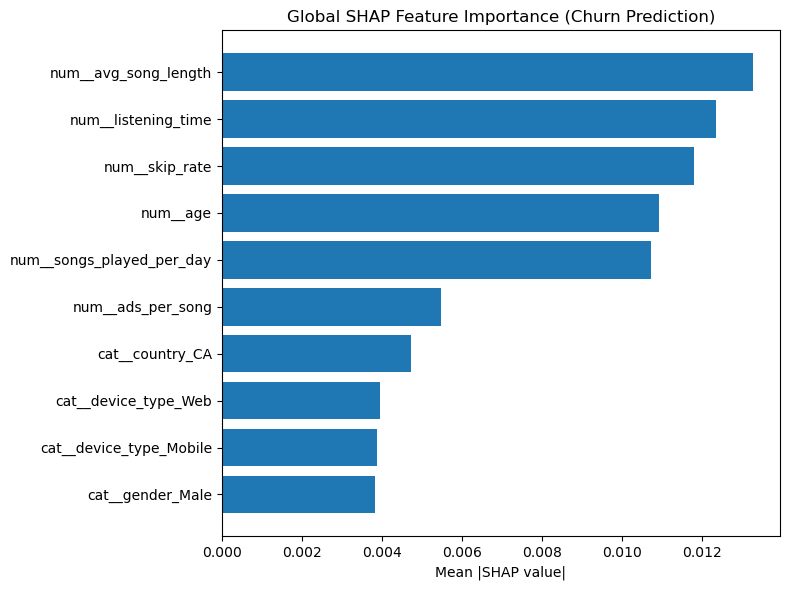

In [6]:
mean_abs_shap = np.mean(np.abs(shap_values[:, :, 1]), axis=0)


preprocessor = joblib.load(DATA_DIR / "preprocessor.joblib")
feature_names = preprocessor.get_feature_names_out()

order = np.argsort(mean_abs_shap)[::-1]

plt.figure(figsize=(8, 6))
plt.barh(
    np.array(feature_names)[order][:10][::-1],
    mean_abs_shap[order][:10][::-1]
)
plt.xlabel("Mean |SHAP value|")
plt.title("Global SHAP Feature Importance (Churn Prediction)")
plt.tight_layout()
plt.savefig(FIG_DIR / "global_shap_importance.png", dpi=300, bbox_inches="tight")
plt.show()

**Interpretation (Global):**  
The SHAP analysis shows that churn predictions are mainly driven by how users engage with the platform. Features like listening time, skip rate, average song length, and songs played per day are the most important, suggesting that users who listen less or skip more are more likely to churn. Age also matters, but it plays a smaller role compared to engagement, while factors like device type and country have only minor influence.

To understand not only which features matter but also whether high or low values increase churn risk, we use a SHAP summary (beeswarm) plot.

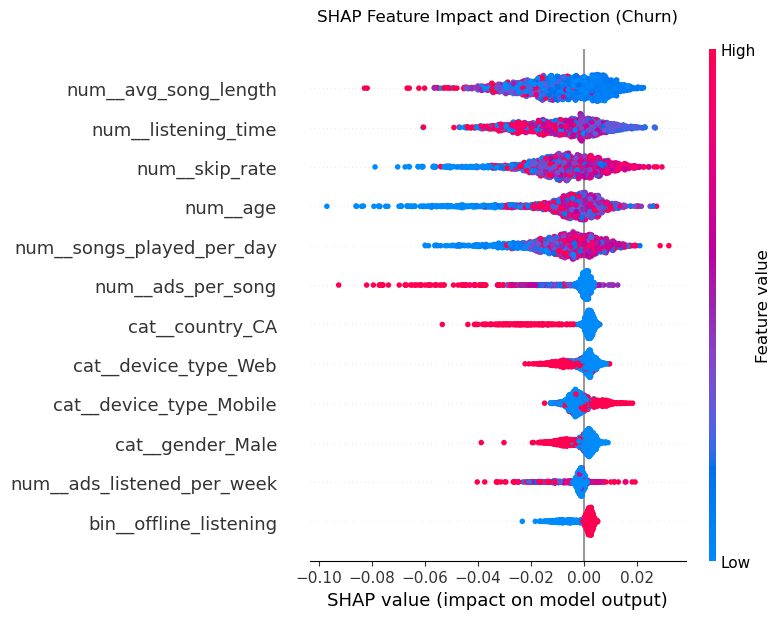

In [7]:
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values[:, :, 1],  
    X_test_dense,
    feature_names=feature_names,
    show=False,
    max_display=12
)
plt.title("SHAP Feature Impact and Direction (Churn)", pad=20)
plt.tight_layout()
plt.savefig(FIG_DIR / "shap_beeswarm.png", dpi=300, bbox_inches="tight")
plt.show()


The beeswarm plot shows both the importance and direction of feature effects. Higher skip rates increase churn risk, while higher listening time and longer average song length reduce churn risk. This confirms that disengagement-related behaviors consistently push predictions toward churn.

To understand how individual predictions are formed, we examine a local SHAP explanation for a user who actually churned.

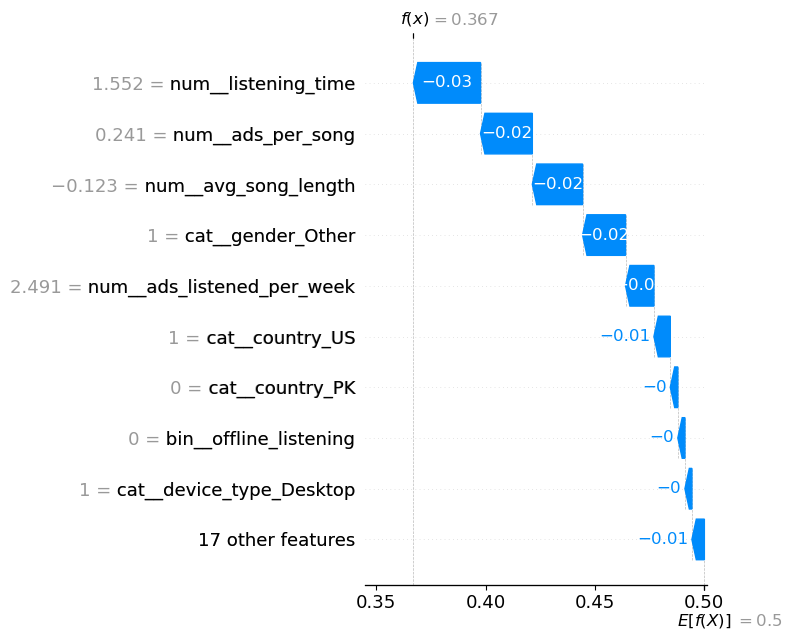

In [8]:
idx = int(np.where(y_test == 1)[0][0])

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[idx, :, 1],
        base_values=explainer.expected_value[1],
        data=X_test_dense[idx],
        feature_names=feature_names,
    ),
    show=False
)
plt.tight_layout()
plt.savefig(FIG_DIR / "local_shap_waterfall.png", dpi=300, bbox_inches="tight")
plt.show()


**Interpretation (Local):**  
This user’s churn risk is lower than average because multiple engagement features, especially listening time and average song length, push the prediction away from churn.

**Limitations**

SHAP explains how the model uses features but does not imply causality. Because
the dataset is observational, external factors such as competing platforms,
pricing changes, or user-specific circumstances are not captured. Additionally,
the Random Forest exhibits low recall for churned users, suggesting that future
work could explore methods to better address class imbalance.


While SHAP identifies which features are important, partial dependence plots help visualize how changes in a specific feature affect churn risk.

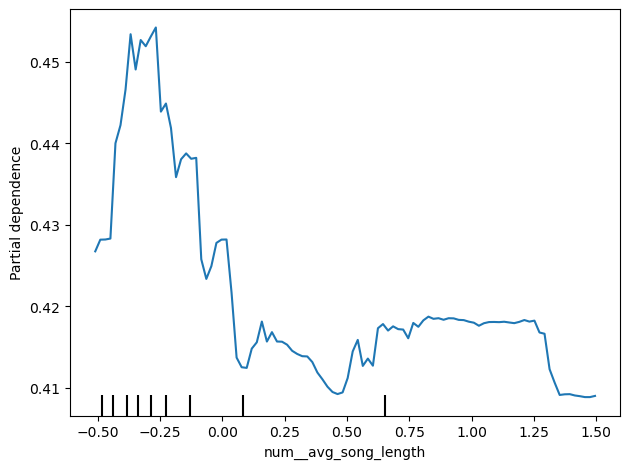

In [9]:
from sklearn.inspection import PartialDependenceDisplay

top_feature = feature_names[order[0]]

PartialDependenceDisplay.from_estimator(
    final_model,
    X_test_dense,
    features=[order[0]],
    feature_names=feature_names
)
plt.tight_layout()
plt.savefig(FIG_DIR / "pdp_num_avg_song_length.png", dpi=300, bbox_inches="tight")
plt.show()


The plot suggests that users who listen to longer songs on average are less likely to churn, while users with very short average song lengths have higher predicted churn risk.


In [10]:
y_pred = final_model.predict(X_test)

false_negatives = np.where((y_test == 1) & (y_pred == 0))[0]
false_positives = np.where((y_test == 0) & (y_pred == 1))[0]

len(false_negatives), len(false_positives)


(351, 191)

The high number of false negatives aligns with the model’s low recall for churn, and also suggests that some churned users still exhibit engagement patterns similar to retained users.

Overall, this analysis shows that churn is driven primarily by engagement behavior, that the model relies on multiple interacting signals rather than single features, and that identifying early churn remains challenging due to overlap between churned and retained users.